<a href="https://colab.research.google.com/github/pratheek08/Grape-Growth-Prediction-Using-Images/blob/main/FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import cv2

In [ ]:
# Define label mapping and dataset path
label_mapping = {'1-Leaf': 0, '2-Budding': 1, '3-Flowering': 2, '4-Stamens and Carpels': 3, '5-Berry Formation': 4, '6-Lag Day': 5, '7-Ripe Day': 6}
dataset_path = "/content/drive/MyDrive/Grape Growth/Dataset"

In [ ]:
# Function to load images and labels
def load_images_and_labels(dataset_path, label_mapping):
    images = []
    labels = []

    for label_str, label_num in label_mapping.items():
        class_folder = os.path.join(dataset_path, label_str)
        for image_file in os.listdir(class_folder):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_path = os.path.join(class_folder, image_file)
                image = cv2.imread(image_path)
                image = cv2.resize(image, (224, 224))  # Resize for ResNet
                images.append(image)
                labels.append(label_num)

    return np.array(images), np.array(labels)

In [ ]:
# Load images and labels
images, labels = load_images_and_labels(dataset_path, label_mapping)
labels = tf.keras.utils.to_categorical(labels, num_classes=len(label_mapping))  # One-hot encoding

In [ ]:
from sklearn.utils import class_weight

# Get class labels as single values instead of one-hot encoded
class_labels = np.argmax(labels, axis=1)

# Count the number of occurrences of each class
class_counts = np.bincount(class_labels)
total_samples = len(class_labels)

# Calculate class weights
class_weights = {i: total_samples / (len(np.unique(class_labels)) * count) for i, count in enumerate(class_counts)}

In [ ]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.25, random_state=42, stratify=class_labels)

In [ ]:
# Load ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_mapping), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
class BestEpochCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.best_accuracy = 0.0
        self.best_loss = float('inf')  # Initialize with a high value
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('val_accuracy')
        current_loss = logs.get('val_loss')
        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.best_loss = current_loss
            self.best_epoch = epoch

In [ ]:
best_epoch_callback = BestEpochCallback()

In [ ]:
# Model checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'
)

In [ ]:
# Image data generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=40, horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=16)
val_generator = val_datagen.flow(X_val, y_val, batch_size=16)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Train the model
history = model.fit(train_generator, epochs=100, validation_data=val_generator,
          Zcallbacks=[best_epoch_callback, checkpoint], class_weight=class_weights)
print(f"Best Epoch: {best_epoch_callback.best_epoch}")
print(f"Best Validation Accuracy: {best_epoch_callback.best_accuracy}")
print(f"Best Validation Loss: {best_epoch_callback.best_loss}")

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 4.9561 - accuracy: 0.3232
Epoch 1: val_accuracy improved from -inf to 0.48485, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 21s 3s/step - loss: 4.9561 - accuracy: 0.3232 - val_loss: 1.8652 - val_accuracy: 0.4848
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 1.8481 - accuracy: 0.5758
Epoch 2: val_accuracy improved from 0.48485 to 0.51515, saving model to best_model.h5
7/7 [==============================] - 17s 2s/step - loss: 1.8481 - accuracy: 0.5758 - val_loss: 2.1657 - val_accuracy: 0.5152
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 1.1627 - accuracy: 0.6970
Epoch 3: val_accuracy improved from 0.51515 to 0.54545, saving model to best_model.h5
7/7 [==============================] - 17s 3s/step - loss: 1.1627 - accuracy: 0.6970 - val_loss: 1.2370 - val_accuracy: 0.5455
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.6152 - accuracy: 0.7980
Epoch 4: val_accuracy improved from 0.54545 to 0.75758, saving model to best_model.h5
7/7 [==============================] - 17s 3s/step - loss: 0.6152 - accuracy: 0.79

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

3/3 [==============================] - 4s 1s/step - loss: 0.5682 - accuracy: 0.7879
Validation Loss: 0.5682403445243835
Validation Accuracy: 0.7878788113594055


In [ ]:
# Train the model
history = model.fit(train_generator, epochs=50, validation_data=val_generator,
                    callbacks=[best_epoch_callback, checkpoint], class_weight=class_weights)
print(f"Best Epoch: {best_epoch_callback.best_epoch}")
print(f"Best Validation Accuracy: {best_epoch_callback.best_accuracy}")
print(f"Best Validation Loss: {best_epoch_callback.best_loss}")

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 2.6534 - accuracy: 0.4343
Epoch 1: val_accuracy improved from -inf to 0.45455, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 35s 5s/step - loss: 2.6534 - accuracy: 0.4343 - val_loss: 1.6171 - val_accuracy: 0.4545
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 1.0006 - accuracy: 0.7071
Epoch 2: val_accuracy improved from 0.45455 to 0.72727, saving model to best_model.h5
7/7 [==============================] - 34s 5s/step - loss: 1.0006 - accuracy: 0.7071 - val_loss: 0.7625 - val_accuracy: 0.7273
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.9357 - accuracy: 0.6465
Epoch 3: val_accuracy did not improve from 0.72727
7/7 [==============================] - 31s 4s/step - loss: 0.9357 - accuracy: 0.6465 - val_loss: 0.9029 - val_accuracy: 0.7273
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.7599 - accuracy: 0.7576
Epoch 4: val_accuracy did not improve from 0.72727
7/7 [==============================] - 34s 5s/step - loss: 0.7599 - accuracy: 0.7576 - val_loss: 0.7569 - val_accuracy: 0.6970
Epoch 5/50
7/7 [============

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

3/3 [==============================] - 7s 1s/step - loss: 0.3793 - accuracy: 0.8788
Validation Loss: 0.37931013107299805
Validation Accuracy: 0.8787878751754761


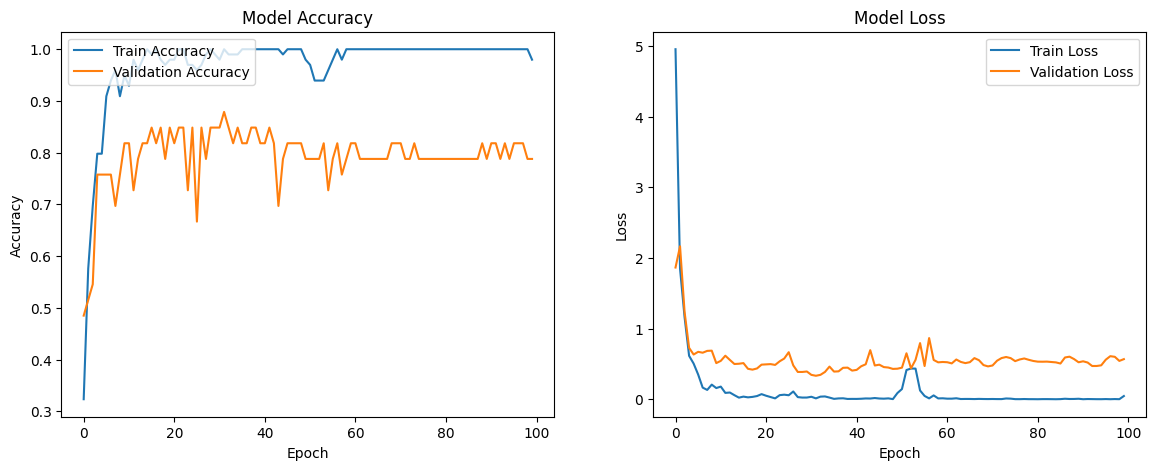

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is a variable containing the training history of the model

# Set up the matplotlib figure and axes for two subplots (1 row, 2 columns)
plt.figure(figsize=(14, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Show the plot
plt.show()


In [ ]:
# Predict on validation data
val_predictions = model.predict(X_val)
val_predicted_classes = np.argmax(val_predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)  # Convert one-hot encoded labels to class indices

2/2 [==============================] - 5s 121ms/step


              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      0.50      0.67         4
           2       0.40      0.80      0.53         5
           3       0.50      0.50      0.50         4
           4       0.75      0.43      0.55         7
           5       0.80      1.00      0.89         4
           6       1.00      1.00      1.00         5

    accuracy                           0.70        33
   macro avg       0.78      0.71      0.71        33
weighted avg       0.77      0.70      0.70        33



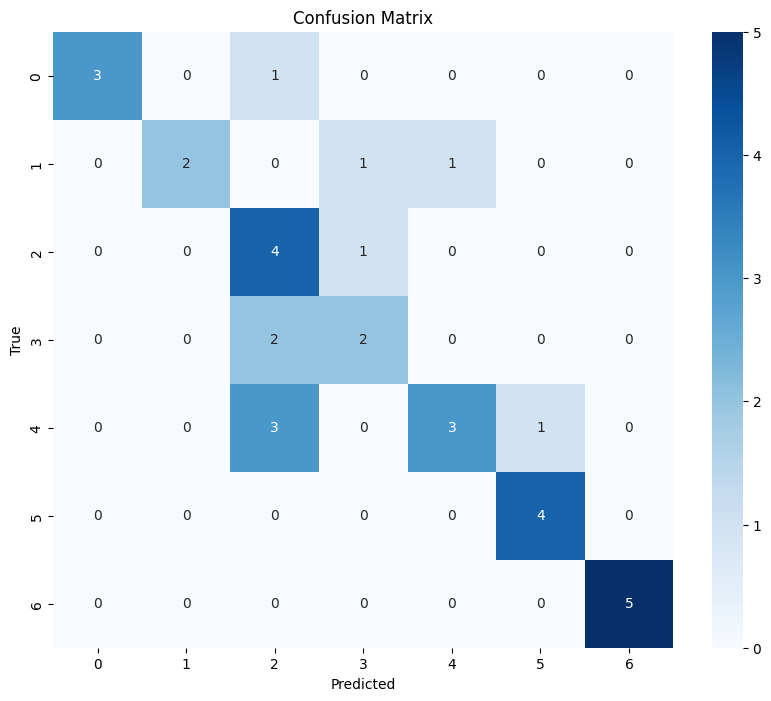

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Define class labels
class_labels = [str(i) for i in range(7)]

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, val_predicted_classes)

# Classification Report
class_report = classification_report(true_classes, val_predicted_classes, target_names=class_labels)
print(class_report)

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Per-class accuracy
from sklearn.metrics import accuracy_score
for i, class_name in enumerate(class_labels):
    class_accuracy = accuracy_score(true_classes == i, val_predicted_classes == i)
    print(f"Accuracy for class {class_name}: {class_accuracy:.2f}")

Accuracy for class 0: 0.97
Accuracy for class 1: 0.94
Accuracy for class 2: 0.79
Accuracy for class 3: 0.88
Accuracy for class 4: 0.85
Accuracy for class 5: 0.97
Accuracy for class 6: 1.00


## random image pick

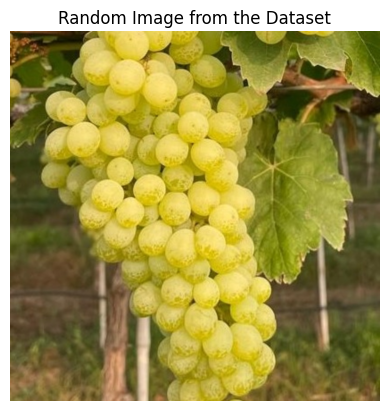

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set the path to your dataset directory
dataset_path = '/content/drive/MyDrive/Grape Growth/Random'

# Get a list of all image files in the dataset directory
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Pick a random image file
random_image_file = random.choice(image_files)

# Construct the full path to the random image
random_image_path = os.path.join(dataset_path, random_image_file)

# Display the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')  # Turn off axis labels
plt.show()

## output1

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the trained model
model = load_model('/content/drive/MyDrive/Colab Notebooks/best_model.h5')  # Provide the correct path to your saved model file

# Define the label mapping
label_mapping = {0: '1-Leaf', 1: '2-Budding', 2: '3-Flowering', 3: '4-Stamens and Carpels', 4: '5-Berry Formation', 5: '6-Lag Day', 6: '7-Ripe Day'}

# Function to preprocess the input image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = preprocess_input(image)
    return np.expand_dims(image, axis=0)

# Function to predict the class of the input image
def predict_class(image_path, model, label_mapping):
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)
    predicted_class_index = np.argmax(predictions)
    predicted_class = label_mapping[predicted_class_index]
    confidence = predictions[0][predicted_class_index]
    return predicted_class, confidence

# Provide the path to the input image
input_image_path = '/content/drive/MyDrive/Grape Growth/Dataset/7-Ripe Day/WhatsApp Image 2023-01-17 at 3.16.00 PM_22_11zon.jpg'  # Replace with the path to your input image

# Make predictions
predicted_class, confidence = predict_class(input_image_path, model, label_mapping)

# Display the results
print(f'Predicted Class: {predicted_class}')
print(f'Confidence: {confidence:.4f}')


1/1 [==============================] - 1s 1s/step
Predicted Class: 7-Ripe Day
Confidence: 0.9969
